In [1]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from scipy import stats

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Get color order
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Data Lab 3 comments based on the homework
1. Permutation test
2. F-test factor of 2
3. T-test function takes axis
4. \# of sig. points
5. Careful with len(array)

#### Sample vs. population

In [2]:
# what does this do?
np.random.seed(42)

# Sample 1
nx = 5
x = np.random.normal(size=nx)

# Sample 2
ny = 7
y = np.random.normal(size=ny) + 1.1

print('Sample means', x.mean(), y.mean())

Sample means 0.45900297432508597 1.2794926855684878


0.0047812481418477775 1.0855968911750027


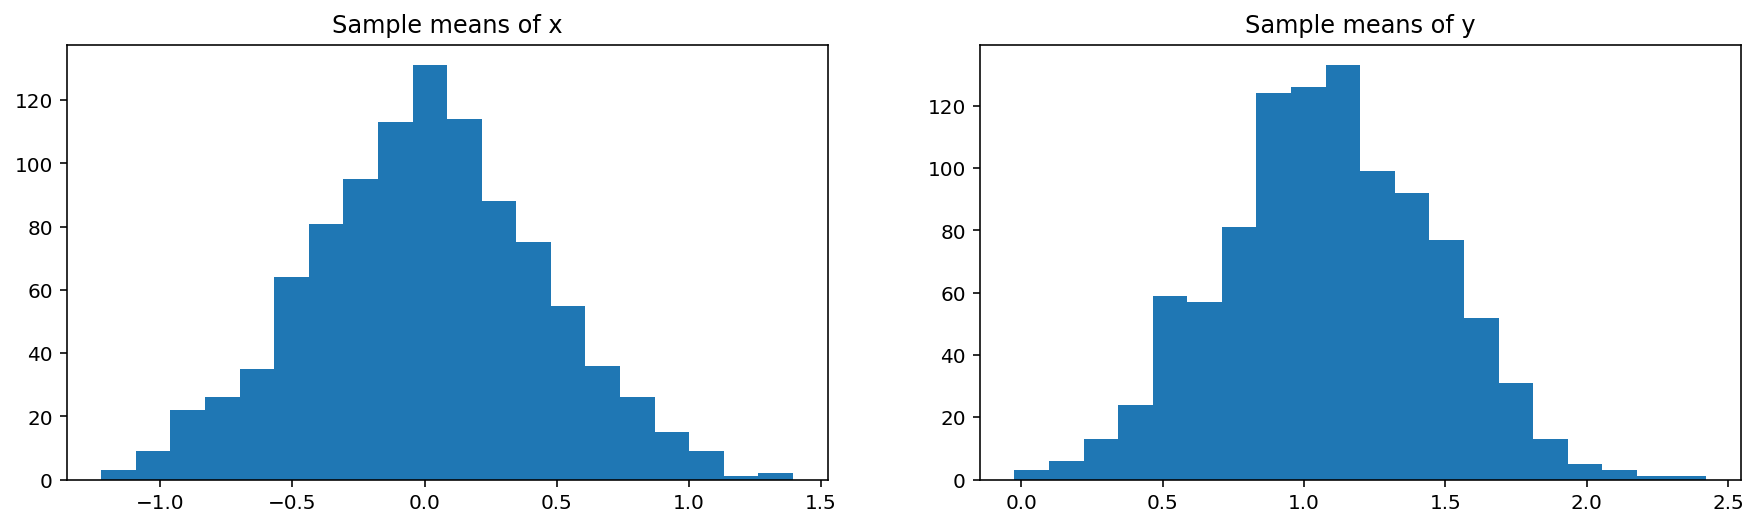

In [3]:
# now draw those samples many times
# each realization is a column
n_sims = 1000

# Sample 1
nx = 5
x = np.random.normal(size=(nx,n_sims))
# Sample 2
ny = 7
y = np.random.normal(size=(ny,n_sims)) + 1.1

print(x.mean(), y.mean())
fig, axs = plt.subplots(1, 2, figsize = (15, 4))
axs[0].hist(x.mean(axis=0), bins = 20)
axs[0].set_title('Sample means of x')
axs[1].hist(y.mean(axis=0), bins = 20)
axs[1].set_title('Sample means of y');

#### Under the null hypothesis (x and y come from the same distribution), p is uniformly distributed.

In [4]:
# Sample 1 and 2 come from the same distribution
# Exchangeability 
np.random.seed(42)

# Sample 1
nx = 5
x = np.random.normal(size=(nx,n_sims))
# Sample 2
ny = 7
y = np.random.normal(size=(ny,n_sims)) 

In [5]:
# Concatenate the two samples
xy = np.concatenate((x,y))
print(xy.shape)

(12, 1000)


1. The p-value is a random variable because it depends on the sample.
2. What is the distribution of $p$ under the null hypothesis?

By definition, we reject the null if $p \le \alpha$, and the probability of rejecting the null when it is true is $\alpha$.

Therefore,
$$ P(p \le \alpha) = \alpha $$
for all $0 \le \alpha \le 1$. This is the uniform distribution.

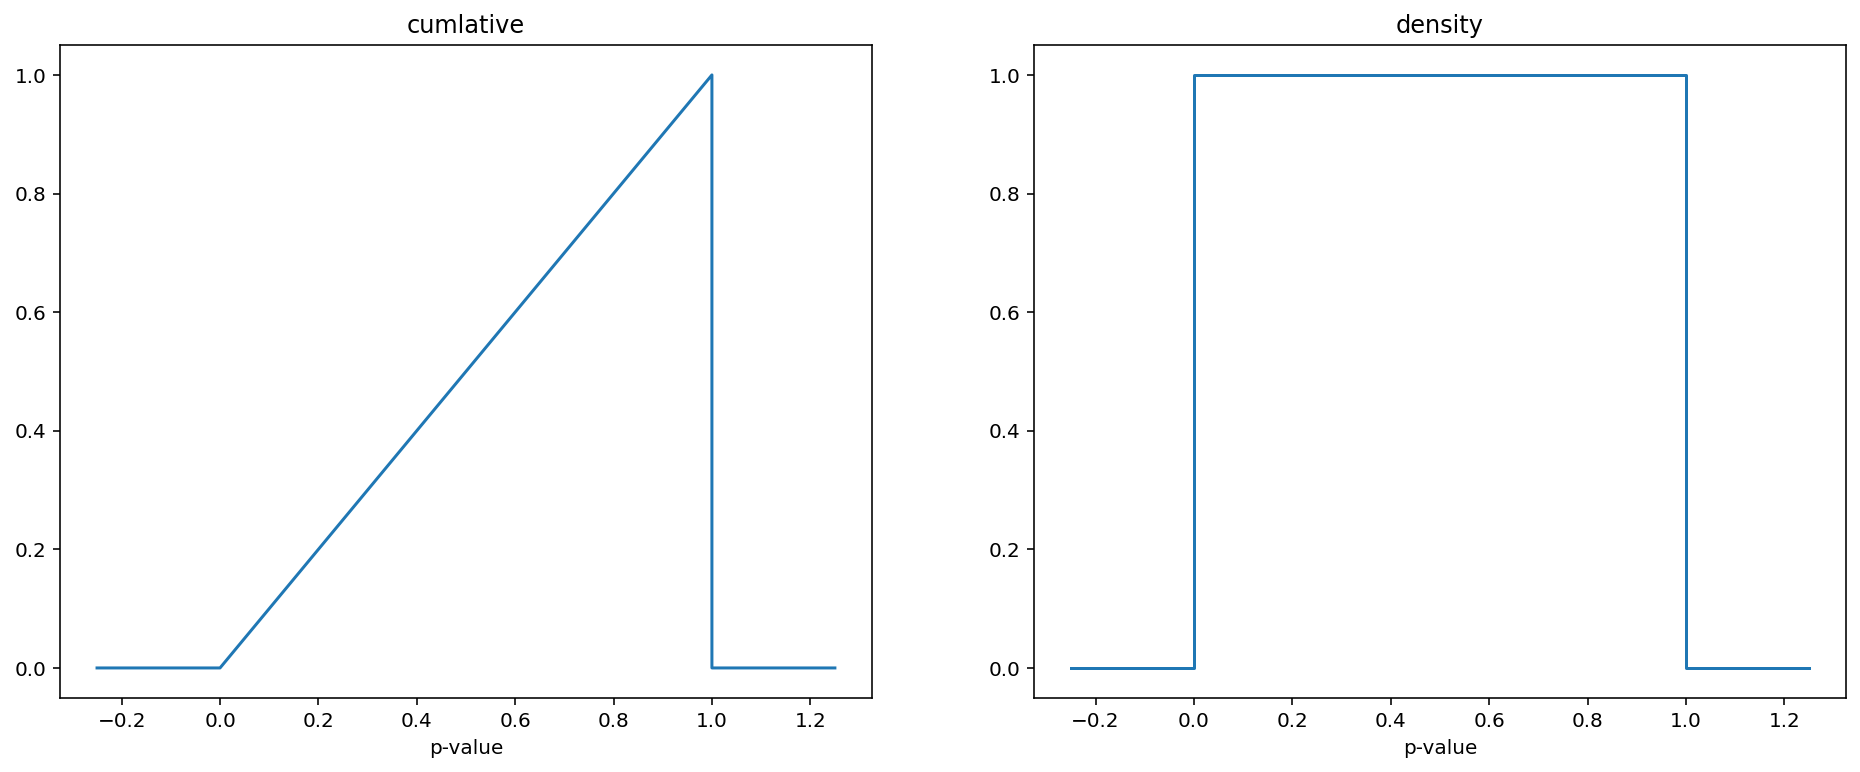

In [6]:
fig, axs = plt.subplots(1, 2, figsize = (16, 6))

ax = axs[0]
ax.plot(np.array([-0.25, 0, 1, 1, 1.25]), np.array([0, 0, 1, 0, 0]))
ax.set_xlabel('p-value')
ax.set_title('cumlative');

ax = axs[1]
ax.plot(np.array([-0.25, 0, 0, 1, 1, 1.25]), np.array([0, 0, 1, 1, 0, 0]))
ax.set_xlabel('p-value')
ax.set_title('density');

5.1

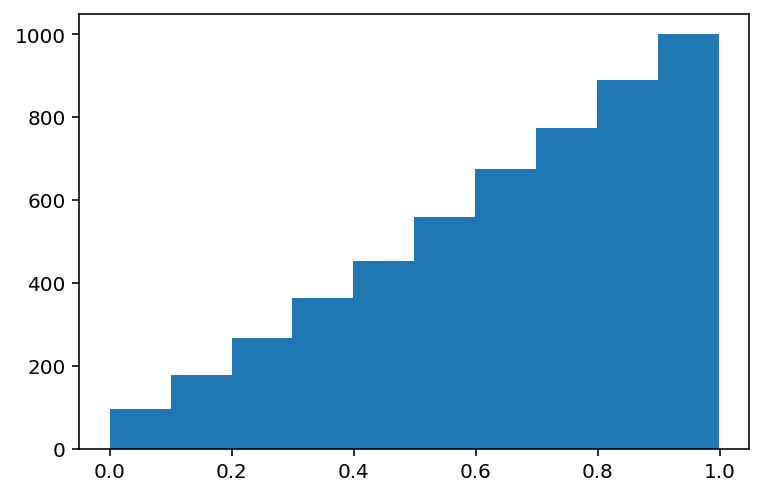

In [7]:
# permutation test code
# Now doing everything to all the columns
ts_star = np.mean(xy[:nx, :]) - np.mean(xy[nx:, :], axis = 0)

mc = 1000
ts = np.empty((mc, n_sims))
for ii in range(0, mc):
    perm_index = np.random.permutation(nx+ny)
    xyr = xy[perm_index, :]
    ts[ii, :] = np.mean(xyr[:nx, :], axis = 0) - np.mean(xyr[nx:, :], axis = 0)
f = np.mean(np.abs(ts_star) <= np.abs(ts), axis = 0) #<----------

p = 2 * np.minimum(f, 1 - f)

plt.hist(np.sort(p), cumulative = True);
np.mean(p <= 0.05)*100.

In [8]:
# example 1 from http://rasbt.github.io/mlxtend/user_guide/evaluate/permutation_test/
treatment = [ 28.44,  29.32,  31.22,  29.58,  30.34,  28.76,  29.21,  30.4 ,
              31.12,  31.78,  27.58,  31.57,  30.73,  30.43,  30.31,  30.32,
              29.18,  29.52,  29.22,  30.56]
control = [ 33.51,  30.63,  32.38,  32.52,  29.41,  30.93,  49.78,  28.96,
            35.77,  31.42,  30.76,  30.6 ,  23.64,  30.54,  47.78,  31.98,
            34.52,  32.42,  31.32,  40.72]
x = treatment
y = control

nx = len(x)
ny = len(y)

xy = np.concatenate((x,y))

# permutation test code
ts_star = np.mean(xy[:nx]) - np.mean(xy[nx:])

mc = 10000
ts = np.empty(mc)
for ii in range(0, mc):
    perm_index = np.random.permutation(nx+ny)
    xyr = xy[perm_index]
    ts[ii] = np.mean(xyr[:nx]) - np.mean(xyr[nx:])
f = np.mean(np.abs(ts_star) < np.abs(ts))
p = np.minimum(1 - f, f)
print(100*p)

0.66


#### P-value from a F-test

In [9]:
# Read JJA Nino 3.4
n34_JJA_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.n34_JJA/dods'
n34_JJA_ds = xr.open_dataset(n34_JJA_url)
n34_JJA = n34_JJA_ds.n34_JJA

n34 = n34_JJA - n34_JJA.mean()
t_nina = n34.values <= -0.4
t_nino = n34.values >= 0.33

# Read Indonesia region rainfall
indo_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.indonesia_prcp_JJA/dods'
indo_ds = xr.open_dataset(indo_url)
prcp_indo = indo_ds.indonesia_prcp_JJA

# Test for difference in variance
Nx = np.count_nonzero(t_nina)
Ny = np.count_nonzero(t_nino)

X = prcp_indo[t_nina]
Y = prcp_indo[t_nino]
print(Y.var() > X.var())

indo_F = Y.var(ddof=1)/X.var(ddof=1)
print(' F = {:4.2f}'.format(indo_F.values))

alpha = 0.05
f_05 = stats.f.ppf(1-alpha/2, Nx - 1, Ny - 1)
print(' f_critical = {:4.2f}'.format(f_05))
print('Cannot reject the null.')

<xarray.DataArray 'indonesia_prcp_JJA' ()>
array(True)
 F = 2.59
 f_critical = 3.72
Cannot reject the null.


Under the null hypothesis, the samples are drawn from populations with the same variance.

The alternative is that $\sigma_X^2 > \sigma_Y^2$ or $\sigma_X^2 < \sigma_Y^2$.

We take as our test statistic 
$$ F = \max \left( \frac{\hat{\sigma}_X^2}{\hat{\sigma}_Y^2}, \frac{\hat{\sigma}_Y^2}{\hat{\sigma}_X^2} \right)  $$
We define a decision rule to reject the null if $F > F_{\text{critical}}$.

We define the significance level $\alpha$ by computing the probability of rejecting when the null holds:
\begin{align*}
P( F > F_{\text{critical}} ) & = \alpha \\
P\left( \frac{\hat{\sigma}_X^2}{\hat{\sigma}_Y^2}> F_{\text{critical}} \text{ or } \frac{\hat{\sigma}_Y^2}{\hat{\sigma}_X^2} > F_{\text{critical}} \right) & = \alpha \\
2 P\left( \frac{\hat{\sigma}_X^2}{\hat{\sigma}_Y^2}> F_{\text{critical}} \right) & = \alpha \\
P\left( \frac{\hat{\sigma}_X^2}{\hat{\sigma}_Y^2}> F_{\text{critical}} \right) & = \frac{\alpha}{2} \\
P\left( \frac{\hat{\sigma}_X^2}{\hat{\sigma}_Y^2} < F_{\text{critical}} \right) & = 1 - \frac{\alpha}{2} 
\end{align*}

$$ F_{\text{critical}} = \text{ppf}^{-1} \left( 1 - \frac{\alpha}{2}, N_X - 1, N_Y - 1 \right) $$

The p-value is the probability under the null of a value as extreme or more than the observed one.

$$ P( F > F_{\text{obs}} ) = P\left( \frac{\hat{\sigma}_X^2}{\hat{\sigma}_Y^2} > F_{\text{obs}} \text{ or } \frac{\hat{\sigma}_Y^2}{\hat{\sigma}_X^2} > F_{\text{obs}} \right) $$

$$= 2 P\left( \frac{\hat{\sigma}_X^2}{\hat{\sigma}_Y^2}> F_{\text{obs}} \right) $$
$$ = 2 \left(1-P\left( \frac{\hat{\sigma}_X^2}{\hat{\sigma}_Y^2}< F_{\text{obs}} \right) \right) $$
$$ = 2 \left(1 - \text{cdf} \left( F_{\text{obs}}, N_X - 1, N_Y -1 \right) \right)$$


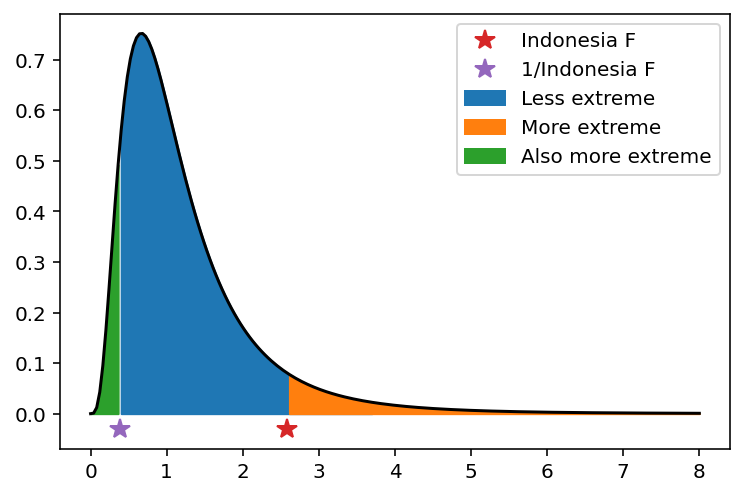

In [14]:
fs = np.linspace(0, 8, 200)
dfn = Nx - 1
dfd = Ny - 1
plt.plot(fs, stats.f.pdf(fs, dfn, dfd), color='k');
plt.plot(indo_F, -0.03, '*', color = colors[3], markersize=10, label = 'Indonesia F')
plt.plot(1./indo_F, -0.03, '*', color = colors[4], markersize=10, label = '1/Indonesia F')

fs_left = fs[(fs <= f_05) & (fs >= 1./indo_F.values)]
fs_middle = fs[fs <= 1./indo_F.values]
fs_right = fs[fs >= indo_F.values]

plt.fill_between(fs_left, stats.f.pdf(fs_left,  dfn, dfd), color = colors[0], label='Less extreme')
plt.fill_between(fs_right, stats.f.pdf(fs_right,  dfn, dfd), color = colors[1], label='More extreme')
plt.fill_between(fs_middle, stats.f.pdf(fs_middle,  dfn, dfd), color = colors[2], label='Also more extreme')

plt.legend();

In [11]:
area_to_right = 1 - stats.f.cdf(indo_F, Nx - 1, Ny - 1)
area_to_left = stats.f.cdf(1./indo_F, Nx - 1, Ny - 1)
print(area_to_right, area_to_left, area_to_right+ area_to_left, 2*(1 - stats.f.cdf(indo_F, Nx - 1, Ny - 1)))
2*stats.f.sf(indo_F, Nx - 1, Ny - 1)

0.07484733833261992 0.07484733833261983 0.14969467666523975 0.14969467666523983


0.14969467666523967

#### Counting points
1. NaN > 0 = False and NaN < 0 = False can cause trouble.

/Users/tippett/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


31.61
31.61
31.61
17.15
31.61
31.61
31.61


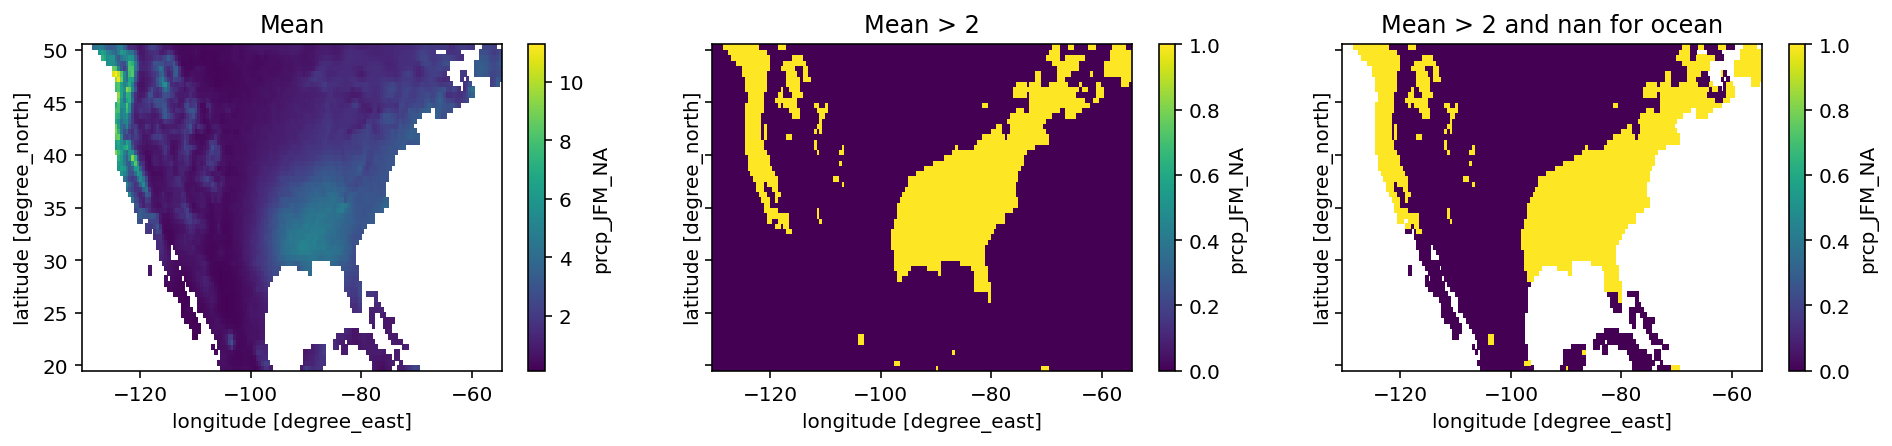

In [12]:
# Read JFM North American precipitation and plot its mean
prcp_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.prcp_JFM_NA/dods'
prcp_ds = xr.open_dataset(prcp_url)
prcp_mean = prcp_ds.prcp_JFM_NA.mean('T')

fig, axs = plt.subplots(1, 3, figsize =(16,3), sharey = True)
prcp_mean.plot(ax = axs[0]);
axs[0].set_title('Mean')

mask = prcp_mean > 2
mask.plot(ax = axs[1])
axs[1].set_title('Mean > 2')

ocean_nan = 0.0*prcp_mean
mask2 = (prcp_mean > 2) + ocean_nan

mask2.plot(ax = axs[2])
axs[2].set_title('Mean > 2 and nan for ocean')

print('{:4.2f}'.format(100*np.nansum(mask2.values) / np.sum(~np.isnan(ocean_nan.values))))
print('{:4.2f}'.format((100*np.sum(mask2) / np.sum(~np.isnan(ocean_nan))).values))
print('{:4.2f}'.format((100*np.mean((prcp_mean > 2) + ocean_nan)).values))
print('{:4.2f}'.format((100*np.mean(prcp_mean > 2)).values)) #<---- wrong
print('{:4.2f}'.format((100*(prcp_mean > 2).where(~np.isnan(prcp_mean)).mean().values))) #<--------------- short and clear
print('{:4.2f}'.format((100*np.mean(np.ravel(prcp_mean)[~np.isnan(np.ravel(prcp_mean))] > 2))))
print('{:4.2f}'.format((100*prcp_mean.where(np.isnan(prcp_mean), prcp_mean > 2).mean().values)))

#### T-distribution for large $N$

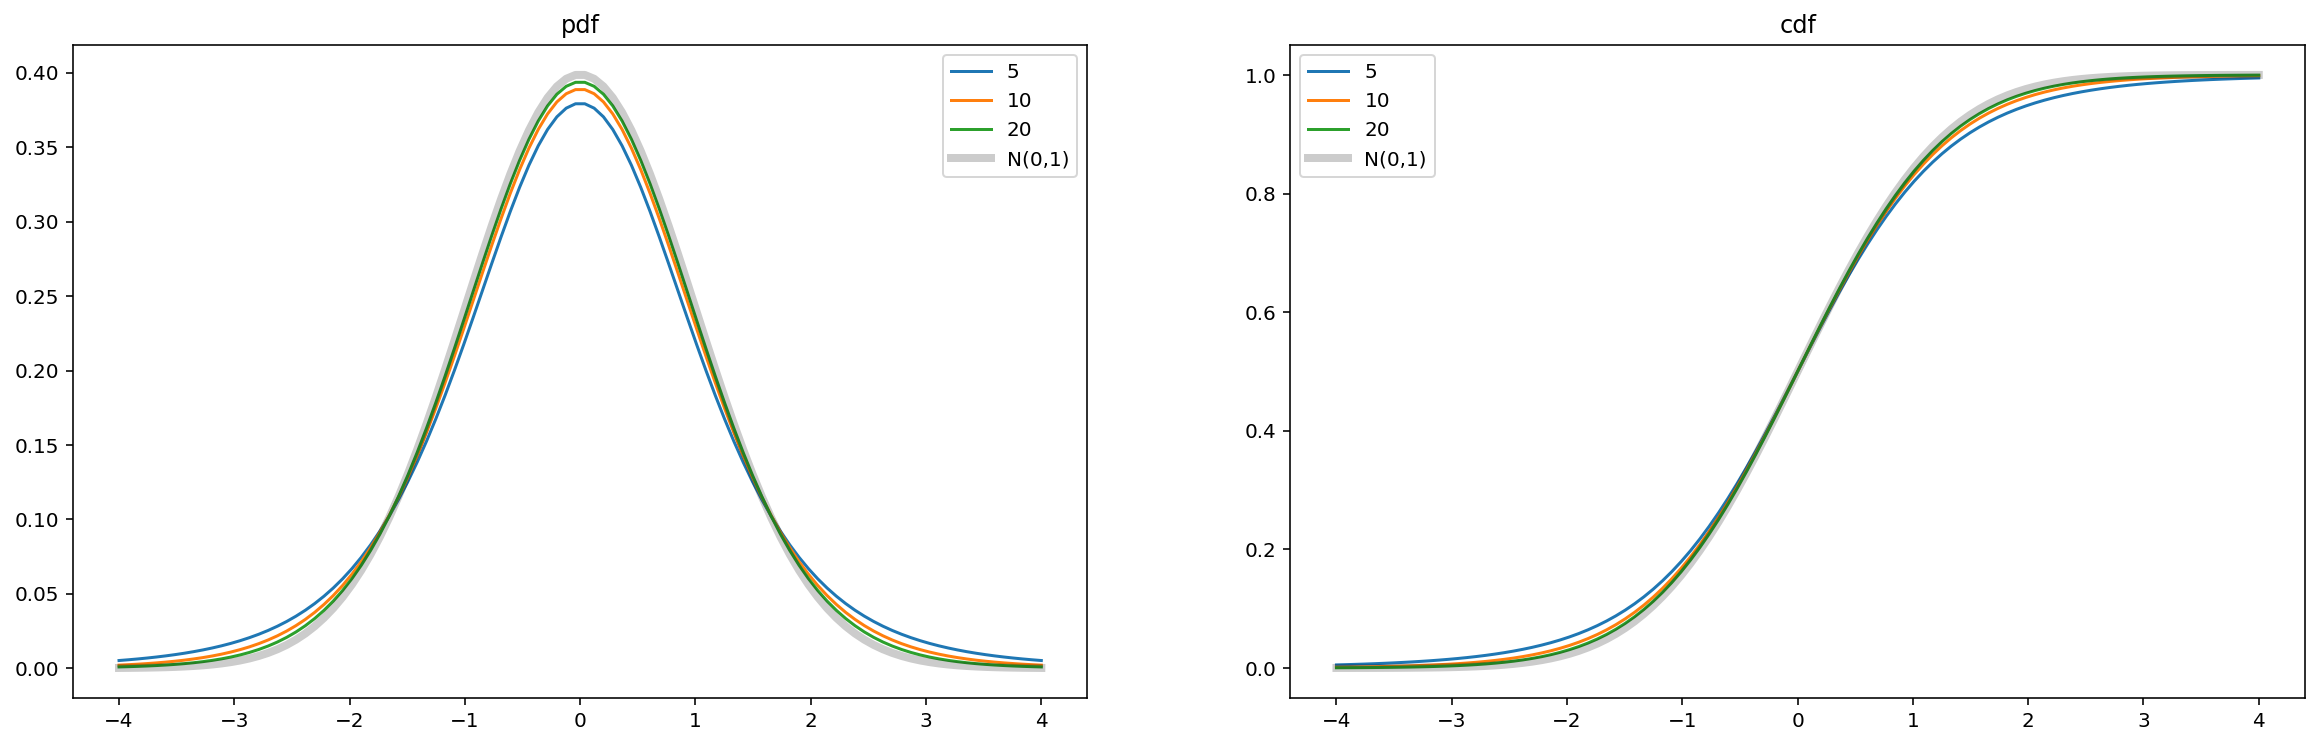

In [13]:
fig, axs = plt.subplots(1, 2, figsize = (20, 6))
z = np.linspace(-4, 4, 100)
Ns = np.array([5, 10, 20])

for N in Ns:
        axs[0].plot(z, stats.t.pdf(z, N), label=N)
        axs[1].plot(z, stats.t.cdf(z, N), label=N)
axs[0].plot(z, stats.norm.pdf(z), 'k', linewidth = 4, alpha = 0.2, label='N(0,1)')
axs[1].plot(z, stats.norm.cdf(z), 'k', linewidth = 4, alpha = 0.2, label='N(0,1)')
axs[0].set_title('pdf')
axs[1].set_title('cdf')

axs[0].legend()
axs[1].legend();

Questions about this week's homework?

![](https://iri.columbia.edu/climate/forecast/net_asmt_nmme/2020/sep2020/images/OND20_World_pcp.gif)